# **Langkah 1: Load Dataset**
*Pada tahap ini, dilakukan proses pengambilan dataset dalam format CSV yang disimpan di GitHub menggunakan pustaka pandas. Setelah dataset berhasil dimuat, lima baris pertama ditampilkan menggunakan fungsi df.head() untuk memastikan bahwa data terbaca dengan benar dan untuk memberikan gambaran awal mengenai struktur serta isi data yang akan dianalisis. Dataset ini berisi hasil survei mengenai kesehatan mental para pekerja di bidang teknologi.*

In [1]:
# ambil csv dari github
import pandas as pd
import requests

url = "https://raw.githubusercontent.com/Aiurskiesyx/ML/refs/heads/main/survey.csv"
df = pd.read_csv(url)
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


# **Langkah 2: Preprocessing Data**
*Pada tahap preprocessing, langkah pertama yang dilakukan adalah menyalin dataset asli ke dalam variabel baru bernama df_clean untuk menjaga data mentah tetap aman dan tidak terpengaruh oleh proses pembersihan. Selanjutnya, tiga kolom yang dianggap tidak relevan untuk proses prediksi, yaitu Timestamp, state, dan comments, dihapus karena tidak memberikan informasi penting atau sulit diproses oleh model. Setelah itu, seluruh baris yang memiliki nilai kosong (missing values) dihapus menggunakan dropna() agar tidak mengganggu proses pelatihan model. Terakhir, dilakukan transformasi terhadap kolom target treatment, yaitu dengan mengubah nilai 'Yes' menjadi 1 dan 'No' menjadi 0, sehingga dapat digunakan sebagai label biner dalam algoritma klasifikasi machine learning. Semua langkah ini bertujuan untuk memastikan bahwa data bersih, relevan, dan siap digunakan dalam proses modeling.*

In [2]:
# Salin data agar data asli tetap aman
df_clean = df.copy()

# Hapus kolom yang tidak berguna untuk prediksi
df_clean.drop(columns=['Timestamp', 'state', 'comments'], inplace=True)


In [3]:
# Hapus semua baris yang memiliki data kosong
df_clean.dropna(inplace=True)


In [4]:
import numpy as np

# Handling outliers using IQR
numeric_cols = df.select_dtypes(include=[np.number]).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Filter rows based on IQR
df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


*Kode ini mendeteksi dan menghapus outlier (data ekstrem) menggunakan metode IQR (Interquartile Range), sehingga model yang dibangun nantinya tidak terpengaruh oleh nilai-nilai yang terlalu jauh dari sebaran normal.*

In [5]:
# Kolom treatment adalah target kita → ubah 'Yes' ke 1 dan 'No' ke 0
df_clean['treatment'] = df_clean['treatment'].map({'Yes': 1, 'No': 0})


In [6]:
from sklearn.preprocessing import LabelEncoder

# Cari semua kolom bertipe object (teks)
categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()

# Lakukan Label Encoding pada semua kolom teks
le = LabelEncoder()
for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

# **Langkah 4: Membagi Data (Train-Test Split)**
*Pada tahap ini, dataset yang telah dibersihkan dan diencoding dibagi menjadi dua bagian, yaitu data fitur (X) dan data target (y). Data fitur mencakup seluruh kolom kecuali kolom treatment, yang merupakan target untuk diprediksi. Selanjutnya, dilakukan pembagian data ke dalam data latih (X_train, y_train) dan data uji (X_test, y_test) menggunakan fungsi train_test_split dari pustaka sklearn. Proporsi pembagian ditentukan sebesar 80% untuk pelatihan dan 20% untuk pengujian. Parameter random_state=42 digunakan agar hasil pembagian bersifat konsisten setiap kali kode dijalankan, sehingga hasil evaluasi model dapat direproduksi dengan stabil.*

In [7]:
from sklearn.model_selection import train_test_split

# Pisahkan fitur dan target
X = df_clean.drop('treatment', axis=1)
y = df_clean['treatment']

# Bagi data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# **Langkah 5: Membangun Model LSTM**

*Selanjutnya membangun model LSTM (Long Short-Term Memory) dengan dua lapisan LSTM dan satu lapisan output sigmoid. Model ini dikompilasi untuk melakukan klasifikasi biner terhadap risiko kebutuhan perawatan kesehatan mental.*

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Arsitektur LSTM sederhana
inputs = Input(shape=(X_train.shape[1], 1))
x = LSTM(64, return_sequences=True)(inputs)
x = LSTM(32)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 23, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 23, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from imblearn.over_sampling import RandomOverSampler

# ✅ Ubah DataFrame ke NumPy array sebelum reshape
X_train_2d = X_train.values.reshape((X_train.shape[0], -1))

# Oversample kelas minoritas
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_2d, y_train)

# Kembalikan ke bentuk 3D
X_train_balanced = X_resampled.reshape((-1, X_train.shape[1], 1))

print("Sebelum oversampling:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Setelah oversampling:", dict(zip(*np.unique(y_resampled, return_counts=True))))

Sebelum oversampling: {np.int64(0): np.int64(285), np.int64(1): np.int64(496)}
Setelah oversampling: {np.int64(0): np.int64(496), np.int64(1): np.int64(496)}


*Menangani ketidakseimbangan kelas dengan teknik oversampling, yaitu memperbanyak data dari kelas minoritas agar model tidak bias. Data diubah ke bentuk 2D sebelum proses, lalu dikembalikan ke format 3D untuk LSTM.*

In [10]:
# Prediksi probabilitas
# Assuming X_test is the correct variable to use and it has the correct shape (num_samples, num_features, 1)
X_test_exp = X_test.values.reshape((-1, X_test.shape[1], 1))  # Reshape X_test to 3D for LSTM
y_pred = model.predict(X_test_exp)

# Threshold klasifikasi biner
threshold = 0.3  # bisa coba 0.4 juga untuk eksperimen
y_pred_binary = (y_pred > threshold).astype(int).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [11]:

from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training dengan data seimbang
history = model.fit(X_train_balanced, y_resampled,
                    validation_data=(X_test_exp, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop])


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5103 - loss: 0.6939 - val_accuracy: 0.6786 - val_loss: 0.6668
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5759 - loss: 0.6817 - val_accuracy: 0.3724 - val_loss: 0.8018
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5424 - loss: 0.6957 - val_accuracy: 0.7551 - val_loss: 0.6113
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6187 - loss: 0.6533 - val_accuracy: 0.7704 - val_loss: 0.5590
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6557 - loss: 0.6204 - val_accuracy: 0.7551 - val_loss: 0.5367
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7088 - loss: 0.5791 - val_accuracy: 0.7857 - val_loss: 0.5507
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6871 - loss: 0.5908 - val_accuracy: 0.7449 - val_loss: 0.5848
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6941 - loss: 0.5867 - val_accuracy: 0.7908 - v

*Pada bagian ini, model dilatih menggunakan data yang telah diseimbangkan. Fitur EarlyStopping digunakan untuk menghentikan pelatihan jika validasi loss tidak membaik setelah 5 epoch, sehingga mencegah overfitting.*

# **Langkah 6: Menampilkan Contoh Hasil Prediksi**
*Langkah ini bertujuan untuk menampilkan hasil prediksi model Random Forest dalam bentuk yang lebih mudah dipahami. Pertama, dibuat pemetaan label numerik ke bentuk teks agar lebih deskriptif, yaitu 0 menjadi "Tidak Pernah Mencari Bantuan" dan 1 menjadi "Pernah Mencari Bantuan". Kemudian, data testing (X_test) disalin untuk membuat tabel hasil yang rapi. Dua kolom baru ditambahkan: Actual berisi label sebenarnya dan Predicted berisi hasil prediksi dari model. Setelah itu, sepuluh baris pertama ditampilkan sebagai contoh, sehingga kita bisa dengan mudah melihat apakah prediksi yang diberikan model sesuai dengan data aktualnya.*

In [12]:
# Mapping angka ke label teks
label_map = {0: 'Tidak Pernah Mencari Bantuan', 1: 'Pernah Mencari Bantuan'}

# Buat prediksi dari model ConvNeXt
y_pred = model.predict(X_test_exp)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()  # Konversi ke 0 atau 1

# Buat salinan data hasil prediksi
hasil_rapi = X_test.copy()
hasil_rapi['Actual'] = y_test.map(label_map)
hasil_rapi['Predicted'] = y_pred_binary
hasil_rapi['Predicted'] = hasil_rapi['Predicted'].map(label_map)

# Lihat 10 contoh hasil prediksi
hasil_rapi.head(10)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


,Age,Gender,Country,self_employed,family_history,work_interfere,no_employees,remote_work,tech_company,benefits,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,Actual,Predicted
280,22,19,0,1,1,3,4,1,1,0,...,0,1,1,2,1,2,1,1,Pernah Mencari Bantuan,Pernah Mencari Bantuan
712,30,35,38,0,1,0,1,0,1,0,...,1,1,1,2,1,0,0,0,Tidak Pernah Mencari Bantuan,Tidak Pernah Mencari Bantuan
246,21,19,38,0,0,1,4,0,0,0,...,0,1,0,0,1,0,0,0,Pernah Mencari Bantuan,Tidak Pernah Mencari Bantuan
1008,39,15,38,0,1,3,4,1,1,1,...,1,1,1,2,0,2,2,0,Pernah Mencari Bantuan,Pernah Mencari Bantuan
106,35,15,38,0,1,3,2,1,1,0,...,1,1,1,2,1,0,1,0,Pernah Mencari Bantuan,Pernah Mencari Bantuan
643,57,19,38,0,0,0,2,0,1,2,...,2,0,0,0,1,0,0,1,Tidak Pernah Mencari Bantuan,Tidak Pernah Mencari Bantuan
925,29,35,38,0,0,3,5,0,1,2,...,2,0,0,0,1,1,0,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan
723,25,19,38,0,1,0,4,1,1,0,...,2,1,1,2,1,1,1,0,Pernah Mencari Bantuan,Pernah Mencari Bantuan
1183,35,32,38,0,1,3,0,1,1,1,...,0,0,1,1,1,1,2,0,Pernah Mencari Bantuan,Pernah Mencari Bantuan
226,32,35,38,0,0,2,0,1,1,1,...,1,1,1,2,1,0,2,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan


In [13]:
# Filter hanya baris yang salah diprediksi
salah_prediksi = hasil_rapi[hasil_rapi['Actual'] != hasil_rapi['Predicted']]
salah_prediksi.head(10)  # Lihat 10 contoh pertama


,Age,Gender,Country,self_employed,family_history,work_interfere,no_employees,remote_work,tech_company,benefits,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,Actual,Predicted
246,21,19,38,0,0,1,4,0,0,0,...,0,1,0,0,1,0,0,0,Pernah Mencari Bantuan,Tidak Pernah Mencari Bantuan
925,29,35,38,0,0,3,5,0,1,2,...,2,0,0,0,1,1,0,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan
226,32,35,38,0,0,2,0,1,1,1,...,1,1,1,2,1,0,2,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan
117,27,19,7,0,0,2,4,0,0,2,...,0,1,1,2,1,1,0,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan
1035,35,19,7,0,1,3,4,1,1,1,...,0,1,0,1,1,1,0,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan
48,26,34,7,1,0,3,0,0,1,1,...,1,1,2,2,1,1,2,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan
341,33,30,38,0,1,3,2,1,1,1,...,2,0,1,1,1,0,1,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan
632,31,19,16,0,0,3,4,1,1,1,...,1,1,2,2,0,0,2,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan
998,32,19,37,0,0,2,3,0,1,1,...,2,1,0,0,1,1,0,0,Tidak Pernah Mencari Bantuan,Pernah Mencari Bantuan
537,26,15,38,0,1,0,5,0,1,0,...,0,1,0,0,1,1,1,0,Pernah Mencari Bantuan,Tidak Pernah Mencari Bantuan


# **Langkah 7: Visualisasi Evaluasi Model**

*Digunakan untuk menilai performa model setelah pelatihan. Di dalamnya, model memprediksi hasil pada data uji dan mengubah probabilitas menjadi kelas biner berdasarkan threshold tertentu. Kemudian, dibuat laporan klasifikasi (classification report) untuk melihat akurasi, precision, recall, dan F1-score. Hasil prediksi dibandingkan dengan label aktual dalam bentuk tabel agar mudah dianalisis. Baris yang salah diprediksi disorot untuk evaluasi lebih lanjut, dan akhirnya ditampilkan confusion matrix sebagai visualisasi performa klasifikasi antara kelas “Pernah” dan “Tidak Pernah” mencari bantuan kesehatan mental.*

In [14]:
from sklearn.metrics import classification_report

# Classification Report tanpa warning
print("Classification Report:")
print(classification_report(
    y_test,
    y_pred_binary,
    target_names=['Tidak Pernah', 'Pernah'],
    digits=4,
    zero_division=0  # ✅ Hilangkan warning jika precision tidak terdefinisi
))


Classification Report:
              precision    recall  f1-score   support

Tidak Pernah     0.8085    0.5588    0.6609        68
      Pernah     0.7987    0.9297    0.8592       128

    accuracy                         0.8010       196
   macro avg     0.8036    0.7443    0.7600       196
weighted avg     0.8021    0.8010    0.7904       196



*Bagian ini mencetak laporan klasifikasi, termasuk metrik seperti precision, recall, dan F1-score untuk setiap kelas, sekaligus menghindari warning jika ada nilai yang tidak terdeteksi oleh model.*

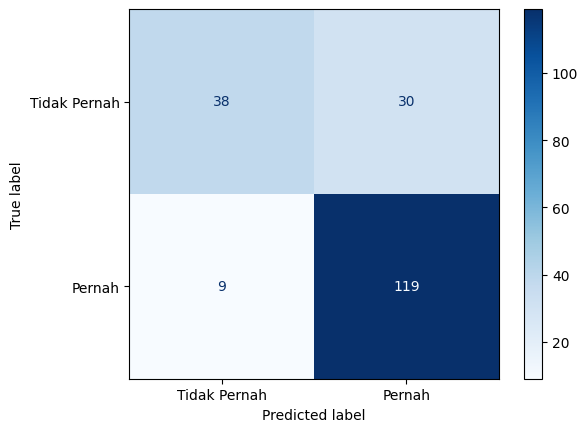

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tidak Pernah', 'Pernah'])
disp.plot(cmap='Blues')
plt.show()

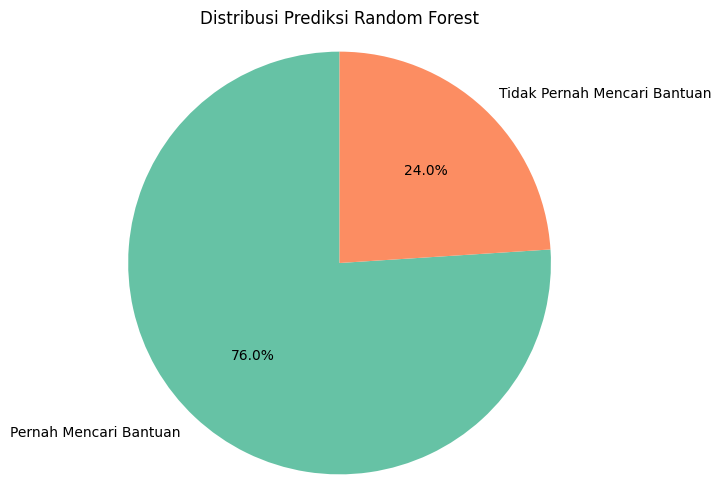

In [16]:
import matplotlib.pyplot as plt

# Pie chart distribusi hasil prediksi
pred_counts = hasil_rapi['Predicted'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(pred_counts, labels=pred_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Distribusi Prediksi Random Forest')
plt.axis('equal')
plt.show()

*Menampilkan pie chart untuk menunjukkan sebaran hasil prediksi model—berapa persen responden yang diprediksi “Pernah” atau “Tidak Pernah” mencari bantuan. Visualisasi ini membantu memahami apakah model cenderung berat ke salah satu kelas (misalnya terlalu banyak memprediksi "Pernah").*

*Kesalahan prediksi terjadi karena model tidak selalu bisa membedakan pola yang halus antara orang yang pernah mencari bantuan dan yang tidak pernah. Misalnya, ada responden yang tidak pernah mencari bantuan, tapi punya riwayat masalah kesehatan mental di keluarga, terganggu pekerjaan karena kondisi mental, atau terbuka bicara ke atasan—fitur-fitur seperti itu bisa “menipu” model untuk memprediksi sebaliknya.*

*Sebaliknya, ada juga yang pernah mencari bantuan, tapi profilnya justru terlihat “normal” di data (misalnya tidak terganggu di kerja, tidak punya riwayat keluarga, dll), sehingga model mengira mereka tidak pernah mencari bantuan.*

*Hal ini wajar terjadi, apalagi jika data tidak seimbang atau fitur-fitur tertentu punya pengaruh yang besar tapi tidak konsisten di seluruh data.*